# CSE251B Final Project Transformer

## Step 1: Import Dependencies:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

In [3]:
train_npz = np.load('cse-251-b-2025/train.npz')
train_data = train_npz['data']
test_npz  = np.load('cse-251-b-2025/test_input.npz')
test_data  = test_npz['data']

### Data Augmentation

In [4]:
X_train = train_data[..., :50, :]

aug_X = []
max_swaps_per_scene = 8  #
for scene in train_data:
    vehicle_indices = []

    # Find vehicle agents (object_type == 0)
    for i in range(1, 50):  # skip agent 0
        agent = scene[i]
        if np.all(agent == 0):
            continue
        if agent[0, 5] == 0:  # 'vehicle'
            vehicle_indices.append(i)

    # Randomly select up to max_swaps_per_scene
    selected = np.random.choice(vehicle_indices, size=min(max_swaps_per_scene, len(vehicle_indices)), replace=False)

    for i in selected:
        swapped_scene = scene.copy()
        swapped_scene[[0, i]] = swapped_scene[[i, 0]]
        aug_X.append(swapped_scene[:, :50, :])  # (50, 50, 6)

# Stack and combine
aug_X = np.stack(aug_X)                          # (N_aug, 50, 50, 6)
X_train_aug = np.concatenate([X_train, aug_X], axis=0)

print("Original X_train shape:", X_train.shape)
print("Augmented X_train shape:", X_train_aug.shape)

X_train = X_train_aug
Y_train = train_data[:, 0, 50:, :2]

Original X_train shape: (10000, 50, 50, 6)
Augmented X_train shape: (89784, 50, 50, 6)


### HeatMap

In [5]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [6]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

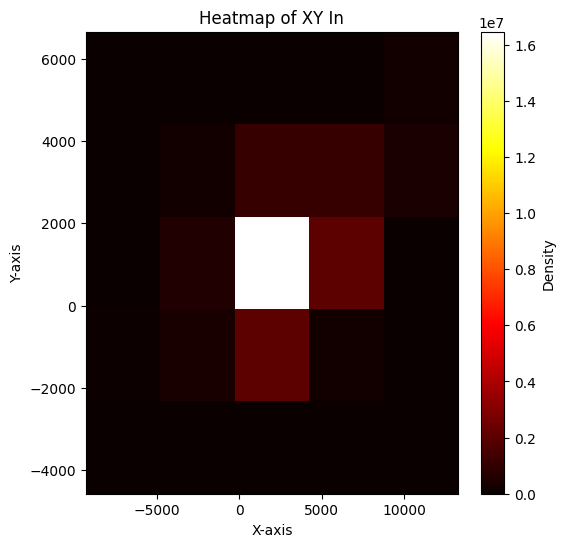

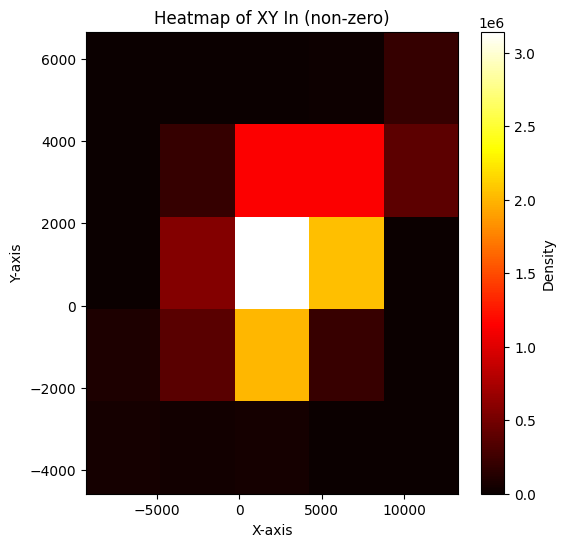

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

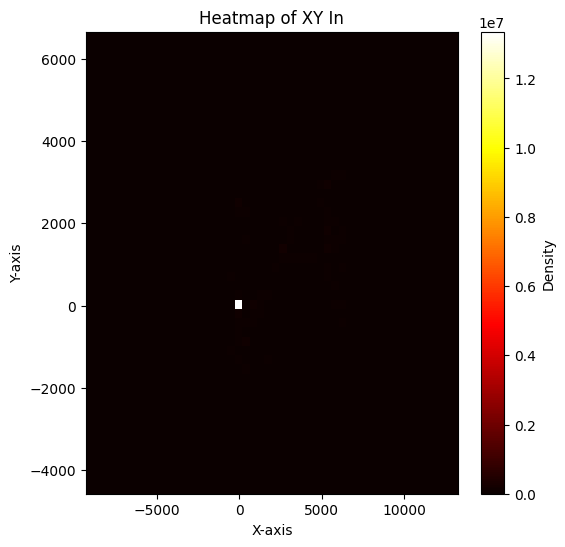

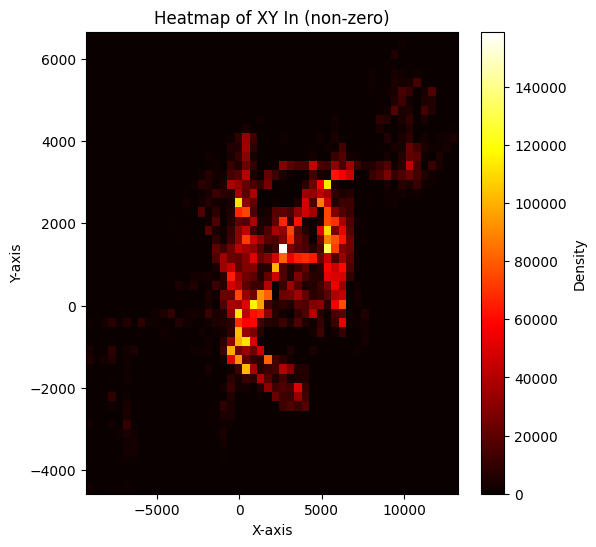

In [8]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

In [9]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [10]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


# Step 4 Transformer Model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import numpy as np
import pandas as pd
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (B, T, D)
        return x + self.pe[:, :x.size(1), :]

class TransformerModel(nn.Module):
    def __init__(self, input_dim=6, d_model=512, nhead=16, num_layers=4, 
                 output_dim=60 * 2, seq_len=50):
        super(TransformerModel, self).__init__()
        self.seq_len = seq_len
        
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model*4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.predict_head = nn.Sequential(
            nn.Linear(d_model * seq_len, d_model*2),
            nn.ReLU(),
            nn.Linear(d_model*2, output_dim)
        )

    def forward(self, data):
        x = data.x.view(-1, 50, 50, 6)[:, 0, :, :]  # (B, T, F)
        B, T, F = x.shape
        
        x = self.input_proj(x)  # (B, T, d_model)
        x = self.pos_encoder(x)
        
        transformer_out = self.transformer(x)  # (B, T, d_model)

        flattened = transformer_out.reshape(B, -1)  # (B, T * d_model)
        
        out = self.predict_head(flattened)  # (B, 120)
        return out.view(-1, 60, 2)  # (B, 60, 2)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(d_model=512, nhead=64, num_layers=4).to(device)


optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)


scheduler = optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=10),
        optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-6)
    ],
    milestones=[10]
)


criterion = nn.SmoothL1Loss(beta=0.5)

early_stopping_patience = 30
best_val_loss = float('inf')
no_improvement = 0

In [14]:
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            pred_denorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y_denorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            val_mae += nn.L1Loss()(pred_denorm, y_denorm).item()
            val_mse += nn.MSELoss()(pred_denorm, y_denorm).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    
    scheduler.step()
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
                   f"Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | "
                   f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}")
    
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stopping triggered!")
            break

Epoch:   0%|                                                                                | 0/100 [00:00<?, ?epoch/s]C:\Users\dysr3\AppData\Local\Temp\ipykernel_29464\3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
C:\Users\dysr3\AppData\Local\Temp\ipykernel_29464\3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|▋                                                                       | 1/100 [00:07<12:57,  7.85s/epoch]

Epoch 000 | LR 0.000033 | Train Loss 0.6371 | Val Loss 0.4269 | Val MAE 4.1362 | Val MSE 51.4742


Epoch:   2%|█▍                                                                      | 2/100 [00:15<12:27,  7.62s/epoch]

Epoch 001 | LR 0.000062 | Train Loss 0.3457 | Val Loss 0.3214 | Val MAE 3.5024 | Val MSE 30.5721


Epoch:   3%|██▏                                                                     | 3/100 [00:22<12:05,  7.48s/epoch]

Epoch 002 | LR 0.000092 | Train Loss 0.2913 | Val Loss 0.2370 | Val MAE 2.8471 | Val MSE 20.5356


Epoch:   4%|██▉                                                                     | 4/100 [00:29<11:51,  7.41s/epoch]

Epoch 003 | LR 0.000122 | Train Loss 0.2605 | Val Loss 0.2249 | Val MAE 2.6844 | Val MSE 18.9448


Epoch:   5%|███▌                                                                    | 5/100 [00:37<11:35,  7.32s/epoch]

Epoch 004 | LR 0.000151 | Train Loss 0.2351 | Val Loss 0.2764 | Val MAE 3.1265 | Val MSE 22.5842


Epoch:   6%|████▎                                                                   | 6/100 [00:44<11:27,  7.32s/epoch]

Epoch 005 | LR 0.000181 | Train Loss 0.2219 | Val Loss 0.2078 | Val MAE 2.5251 | Val MSE 16.9730


Epoch:   7%|█████                                                                   | 7/100 [00:51<11:15,  7.26s/epoch]

Epoch 006 | LR 0.000211 | Train Loss 0.2097 | Val Loss 0.2214 | Val MAE 2.6762 | Val MSE 18.0296


Epoch:   8%|█████▊                                                                  | 8/100 [00:58<11:04,  7.22s/epoch]

Epoch 007 | LR 0.000241 | Train Loss 0.2177 | Val Loss 0.2087 | Val MAE 2.5539 | Val MSE 16.7070


Epoch:   9%|██████▍                                                                 | 9/100 [01:05<10:58,  7.24s/epoch]

Epoch 008 | LR 0.000270 | Train Loss 0.2124 | Val Loss 0.1962 | Val MAE 2.3925 | Val MSE 17.0091


C:\Users\dysr3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch:  10%|███████                                                                | 10/100 [01:13<10:49,  7.21s/epoch]

Epoch 009 | LR 0.000300 | Train Loss 0.2130 | Val Loss 0.2337 | Val MAE 2.6546 | Val MSE 21.2018


Epoch:  11%|███████▊                                                               | 11/100 [01:20<10:39,  7.19s/epoch]

Epoch 010 | LR 0.000300 | Train Loss 0.2169 | Val Loss 0.2038 | Val MAE 2.4845 | Val MSE 17.1363


Epoch:  12%|████████▌                                                              | 12/100 [01:27<10:31,  7.18s/epoch]

Epoch 011 | LR 0.000298 | Train Loss 0.2150 | Val Loss 0.2801 | Val MAE 3.2153 | Val MSE 23.4723


Epoch:  13%|█████████▏                                                             | 13/100 [01:34<10:27,  7.21s/epoch]

Epoch 012 | LR 0.000296 | Train Loss 0.1965 | Val Loss 0.1889 | Val MAE 2.3517 | Val MSE 15.9649


Epoch:  14%|█████████▉                                                             | 14/100 [01:41<10:22,  7.24s/epoch]

Epoch 013 | LR 0.000293 | Train Loss 0.1898 | Val Loss 0.1704 | Val MAE 2.1854 | Val MSE 13.9867


Epoch:  15%|██████████▋                                                            | 15/100 [01:49<10:12,  7.21s/epoch]

Epoch 014 | LR 0.000289 | Train Loss 0.1895 | Val Loss 0.1897 | Val MAE 2.3502 | Val MSE 15.8646


Epoch:  16%|███████████▎                                                           | 16/100 [01:56<10:07,  7.23s/epoch]

Epoch 015 | LR 0.000284 | Train Loss 0.1837 | Val Loss 0.1541 | Val MAE 1.9049 | Val MSE 13.2494


Epoch:  17%|████████████                                                           | 17/100 [02:03<09:57,  7.20s/epoch]

Epoch 016 | LR 0.000278 | Train Loss 0.1759 | Val Loss 0.1757 | Val MAE 2.1464 | Val MSE 14.5912


Epoch:  18%|████████████▊                                                          | 18/100 [02:10<09:47,  7.17s/epoch]

Epoch 017 | LR 0.000271 | Train Loss 0.1698 | Val Loss 0.1558 | Val MAE 1.9619 | Val MSE 13.2597


Epoch:  19%|█████████████▍                                                         | 19/100 [02:17<09:41,  7.18s/epoch]

Epoch 018 | LR 0.000264 | Train Loss 0.1654 | Val Loss 0.1331 | Val MAE 1.7311 | Val MSE 11.2769


Epoch:  20%|██████████████▏                                                        | 20/100 [02:24<09:33,  7.17s/epoch]

Epoch 019 | LR 0.000256 | Train Loss 0.1582 | Val Loss 0.1416 | Val MAE 1.7577 | Val MSE 12.1102


Epoch:  21%|██████████████▉                                                        | 21/100 [02:32<09:25,  7.16s/epoch]

Epoch 020 | LR 0.000248 | Train Loss 0.1518 | Val Loss 0.1578 | Val MAE 1.9714 | Val MSE 12.9721


Epoch:  22%|███████████████▌                                                       | 22/100 [02:39<09:24,  7.24s/epoch]

Epoch 021 | LR 0.000238 | Train Loss 0.1480 | Val Loss 0.1657 | Val MAE 2.0715 | Val MSE 13.6692


Epoch:  23%|████████████████▎                                                      | 23/100 [02:46<09:15,  7.21s/epoch]

Epoch 022 | LR 0.000229 | Train Loss 0.1437 | Val Loss 0.1553 | Val MAE 1.9777 | Val MSE 12.5945


Epoch:  24%|█████████████████                                                      | 24/100 [02:53<09:05,  7.17s/epoch]

Epoch 023 | LR 0.000218 | Train Loss 0.1409 | Val Loss 0.1507 | Val MAE 1.9329 | Val MSE 12.1545


Epoch:  25%|█████████████████▊                                                     | 25/100 [03:00<08:58,  7.17s/epoch]

Epoch 024 | LR 0.000208 | Train Loss 0.1353 | Val Loss 0.1407 | Val MAE 1.8743 | Val MSE 11.1506


Epoch:  26%|██████████████████▍                                                    | 26/100 [03:08<08:54,  7.23s/epoch]

Epoch 025 | LR 0.000197 | Train Loss 0.1332 | Val Loss 0.1243 | Val MAE 1.6171 | Val MSE 10.1918


Epoch:  27%|███████████████████▏                                                   | 27/100 [03:15<08:45,  7.20s/epoch]

Epoch 026 | LR 0.000185 | Train Loss 0.1302 | Val Loss 0.1361 | Val MAE 1.7539 | Val MSE 10.6379


Epoch:  28%|███████████████████▉                                                   | 28/100 [03:22<08:36,  7.18s/epoch]

Epoch 027 | LR 0.000174 | Train Loss 0.1295 | Val Loss 0.1348 | Val MAE 1.7196 | Val MSE 11.1441


Epoch:  29%|████████████████████▌                                                  | 29/100 [03:29<08:28,  7.16s/epoch]

Epoch 028 | LR 0.000162 | Train Loss 0.1272 | Val Loss 0.1245 | Val MAE 1.6208 | Val MSE 10.2990


Epoch:  30%|█████████████████████▎                                                 | 30/100 [03:36<08:20,  7.15s/epoch]

Epoch 029 | LR 0.000150 | Train Loss 0.1247 | Val Loss 0.1296 | Val MAE 1.6869 | Val MSE 10.4185


Epoch:  31%|██████████████████████                                                 | 31/100 [03:43<08:12,  7.14s/epoch]

Epoch 030 | LR 0.000139 | Train Loss 0.1234 | Val Loss 0.1282 | Val MAE 1.6348 | Val MSE 10.5570


Epoch:  32%|██████████████████████▋                                                | 32/100 [03:51<08:08,  7.18s/epoch]

Epoch 031 | LR 0.000127 | Train Loss 0.1210 | Val Loss 0.1141 | Val MAE 1.5265 | Val MSE 9.2538


Epoch:  33%|███████████████████████▍                                               | 33/100 [03:58<08:02,  7.20s/epoch]

Epoch 032 | LR 0.000116 | Train Loss 0.1180 | Val Loss 0.1104 | Val MAE 1.4390 | Val MSE 9.0831


Epoch:  34%|████████████████████████▏                                              | 34/100 [04:05<07:54,  7.18s/epoch]

Epoch 033 | LR 0.000104 | Train Loss 0.1178 | Val Loss 0.1223 | Val MAE 1.6171 | Val MSE 9.9978


Epoch:  35%|████████████████████████▊                                              | 35/100 [04:12<07:45,  7.16s/epoch]

Epoch 034 | LR 0.000093 | Train Loss 0.1158 | Val Loss 0.1106 | Val MAE 1.4708 | Val MSE 8.8765


Epoch:  36%|█████████████████████████▌                                             | 36/100 [04:20<07:42,  7.22s/epoch]

Epoch 035 | LR 0.000083 | Train Loss 0.1133 | Val Loss 0.1087 | Val MAE 1.3973 | Val MSE 9.0345


Epoch:  37%|██████████████████████████▎                                            | 37/100 [04:27<07:39,  7.29s/epoch]

Epoch 036 | LR 0.000072 | Train Loss 0.1126 | Val Loss 0.1106 | Val MAE 1.4574 | Val MSE 9.1189


Epoch:  38%|██████████████████████████▉                                            | 38/100 [04:34<07:31,  7.28s/epoch]

Epoch 037 | LR 0.000063 | Train Loss 0.1100 | Val Loss 0.1036 | Val MAE 1.3744 | Val MSE 8.6234


Epoch:  39%|███████████████████████████▋                                           | 39/100 [04:42<07:23,  7.27s/epoch]

Epoch 038 | LR 0.000053 | Train Loss 0.1086 | Val Loss 0.1023 | Val MAE 1.3667 | Val MSE 8.5094


Epoch:  40%|████████████████████████████▍                                          | 40/100 [04:49<07:12,  7.22s/epoch]

Epoch 039 | LR 0.000045 | Train Loss 0.1063 | Val Loss 0.1071 | Val MAE 1.3780 | Val MSE 8.8651


Epoch:  41%|█████████████████████████████                                          | 41/100 [04:56<07:05,  7.21s/epoch]

Epoch 040 | LR 0.000037 | Train Loss 0.1055 | Val Loss 0.1053 | Val MAE 1.3375 | Val MSE 8.8436


Epoch:  42%|█████████████████████████████▊                                         | 42/100 [05:03<07:01,  7.26s/epoch]

Epoch 041 | LR 0.000030 | Train Loss 0.1045 | Val Loss 0.1032 | Val MAE 1.3261 | Val MSE 8.6899


Epoch:  43%|██████████████████████████████▌                                        | 43/100 [05:10<06:51,  7.23s/epoch]

Epoch 042 | LR 0.000023 | Train Loss 0.1034 | Val Loss 0.1024 | Val MAE 1.3189 | Val MSE 8.5392


Epoch:  44%|███████████████████████████████▏                                       | 44/100 [05:17<06:42,  7.18s/epoch]

Epoch 043 | LR 0.000017 | Train Loss 0.1024 | Val Loss 0.1042 | Val MAE 1.3484 | Val MSE 8.7541


Epoch:  45%|███████████████████████████████▉                                       | 45/100 [05:25<06:34,  7.17s/epoch]

Epoch 044 | LR 0.000012 | Train Loss 0.1009 | Val Loss 0.1041 | Val MAE 1.3448 | Val MSE 8.6419


Epoch:  46%|████████████████████████████████▋                                      | 46/100 [05:32<06:27,  7.18s/epoch]

Epoch 045 | LR 0.000008 | Train Loss 0.1005 | Val Loss 0.1014 | Val MAE 1.2938 | Val MSE 8.4859


Epoch:  47%|█████████████████████████████████▎                                     | 47/100 [05:39<06:22,  7.21s/epoch]

Epoch 046 | LR 0.000005 | Train Loss 0.1000 | Val Loss 0.0996 | Val MAE 1.2742 | Val MSE 8.3345


Epoch:  48%|██████████████████████████████████                                     | 48/100 [05:46<06:15,  7.22s/epoch]

Epoch 047 | LR 0.000003 | Train Loss 0.0994 | Val Loss 0.0994 | Val MAE 1.2662 | Val MSE 8.3163


Epoch:  49%|██████████████████████████████████▊                                    | 49/100 [05:53<06:06,  7.19s/epoch]

Epoch 048 | LR 0.000001 | Train Loss 0.0991 | Val Loss 0.0993 | Val MAE 1.2677 | Val MSE 8.3232


Epoch:  50%|███████████████████████████████████▌                                   | 50/100 [06:01<05:59,  7.20s/epoch]

Epoch 049 | LR 0.000001 | Train Loss 0.0987 | Val Loss 0.0992 | Val MAE 1.2632 | Val MSE 8.2920


Epoch:  51%|████████████████████████████████████▏                                  | 51/100 [06:08<05:51,  7.17s/epoch]

Epoch 050 | LR 0.000001 | Train Loss 0.0988 | Val Loss 0.0992 | Val MAE 1.2641 | Val MSE 8.2958


Epoch:  52%|████████████████████████████████████▉                                  | 52/100 [06:15<05:44,  7.19s/epoch]

Epoch 051 | LR 0.000003 | Train Loss 0.0984 | Val Loss 0.0989 | Val MAE 1.2620 | Val MSE 8.2679


Epoch:  53%|█████████████████████████████████████▋                                 | 53/100 [06:22<05:38,  7.20s/epoch]

Epoch 052 | LR 0.000005 | Train Loss 0.0987 | Val Loss 0.0987 | Val MAE 1.2578 | Val MSE 8.2407


Epoch:  54%|██████████████████████████████████████▎                                | 54/100 [06:29<05:31,  7.20s/epoch]

Epoch 053 | LR 0.000008 | Train Loss 0.0987 | Val Loss 0.0982 | Val MAE 1.2591 | Val MSE 8.2030


Epoch:  55%|███████████████████████████████████████                                | 55/100 [06:36<05:22,  7.17s/epoch]

Epoch 054 | LR 0.000012 | Train Loss 0.0993 | Val Loss 0.0984 | Val MAE 1.2740 | Val MSE 8.2130


Epoch:  56%|███████████████████████████████████████▊                               | 56/100 [06:44<05:14,  7.15s/epoch]

Epoch 055 | LR 0.000017 | Train Loss 0.0996 | Val Loss 0.1016 | Val MAE 1.3108 | Val MSE 8.4554


Epoch:  57%|████████████████████████████████████████▍                              | 57/100 [06:51<05:06,  7.14s/epoch]

Epoch 056 | LR 0.000023 | Train Loss 0.1002 | Val Loss 0.1014 | Val MAE 1.3123 | Val MSE 8.3777


Epoch:  58%|█████████████████████████████████████████▏                             | 58/100 [06:58<05:01,  7.17s/epoch]

Epoch 057 | LR 0.000030 | Train Loss 0.1020 | Val Loss 0.0980 | Val MAE 1.2714 | Val MSE 8.1452


Epoch:  59%|█████████████████████████████████████████▉                             | 59/100 [07:05<04:53,  7.16s/epoch]

Epoch 058 | LR 0.000037 | Train Loss 0.1018 | Val Loss 0.0987 | Val MAE 1.3078 | Val MSE 8.1042


Epoch:  60%|██████████████████████████████████████████▌                            | 60/100 [07:12<04:45,  7.13s/epoch]

Epoch 059 | LR 0.000045 | Train Loss 0.1014 | Val Loss 0.1023 | Val MAE 1.3238 | Val MSE 8.4593


Epoch:  61%|███████████████████████████████████████████▎                           | 61/100 [07:19<04:37,  7.13s/epoch]

Epoch 060 | LR 0.000053 | Train Loss 0.1029 | Val Loss 0.1054 | Val MAE 1.3663 | Val MSE 8.7352


Epoch:  62%|████████████████████████████████████████████                           | 62/100 [07:26<04:28,  7.07s/epoch]

Epoch 061 | LR 0.000063 | Train Loss 0.1049 | Val Loss 0.1021 | Val MAE 1.3593 | Val MSE 8.2879


Epoch:  63%|████████████████████████████████████████████▋                          | 63/100 [07:33<04:19,  7.02s/epoch]

Epoch 062 | LR 0.000072 | Train Loss 0.1060 | Val Loss 0.1108 | Val MAE 1.4392 | Val MSE 9.1754


Epoch:  64%|█████████████████████████████████████████████▍                         | 64/100 [07:40<04:13,  7.03s/epoch]

Epoch 063 | LR 0.000083 | Train Loss 0.1063 | Val Loss 0.1064 | Val MAE 1.3876 | Val MSE 8.8035


Epoch:  65%|██████████████████████████████████████████████▏                        | 65/100 [07:47<04:06,  7.03s/epoch]

Epoch 064 | LR 0.000093 | Train Loss 0.1082 | Val Loss 0.1069 | Val MAE 1.4721 | Val MSE 8.8044


Epoch:  66%|██████████████████████████████████████████████▊                        | 66/100 [07:54<03:59,  7.04s/epoch]

Epoch 065 | LR 0.000104 | Train Loss 0.1090 | Val Loss 0.1064 | Val MAE 1.3919 | Val MSE 8.7911


Epoch:  67%|███████████████████████████████████████████████▌                       | 67/100 [08:01<03:52,  7.03s/epoch]

Epoch 066 | LR 0.000116 | Train Loss 0.1111 | Val Loss 0.1115 | Val MAE 1.5579 | Val MSE 8.9208


Epoch:  68%|████████████████████████████████████████████████▎                      | 68/100 [08:08<03:45,  7.04s/epoch]

Epoch 067 | LR 0.000127 | Train Loss 0.1118 | Val Loss 0.1134 | Val MAE 1.5265 | Val MSE 9.1184


Epoch:  69%|████████████████████████████████████████████████▉                      | 69/100 [08:15<03:38,  7.04s/epoch]

Epoch 068 | LR 0.000139 | Train Loss 0.1129 | Val Loss 0.1143 | Val MAE 1.5489 | Val MSE 9.2214


Epoch:  70%|█████████████████████████████████████████████████▋                     | 70/100 [08:22<03:31,  7.05s/epoch]

Epoch 069 | LR 0.000151 | Train Loss 0.1151 | Val Loss 0.1090 | Val MAE 1.4326 | Val MSE 8.9766


Epoch:  71%|██████████████████████████████████████████████████▍                    | 71/100 [08:29<03:24,  7.05s/epoch]

Epoch 070 | LR 0.000162 | Train Loss 0.1148 | Val Loss 0.1303 | Val MAE 1.7375 | Val MSE 10.7272


Epoch:  72%|███████████████████████████████████████████████████                    | 72/100 [08:37<03:17,  7.05s/epoch]

Epoch 071 | LR 0.000174 | Train Loss 0.1165 | Val Loss 0.1163 | Val MAE 1.5347 | Val MSE 9.4783


Epoch:  73%|███████████████████████████████████████████████████▊                   | 73/100 [08:44<03:10,  7.06s/epoch]

Epoch 072 | LR 0.000185 | Train Loss 0.1177 | Val Loss 0.1179 | Val MAE 1.5657 | Val MSE 9.3432


Epoch:  74%|████████████████████████████████████████████████████▌                  | 74/100 [08:51<03:03,  7.06s/epoch]

Epoch 073 | LR 0.000197 | Train Loss 0.1194 | Val Loss 0.1227 | Val MAE 1.6314 | Val MSE 10.2343


Epoch:  75%|█████████████████████████████████████████████████████▎                 | 75/100 [08:58<02:56,  7.05s/epoch]

Epoch 074 | LR 0.000208 | Train Loss 0.1202 | Val Loss 0.1211 | Val MAE 1.6230 | Val MSE 9.3734


Epoch:  76%|█████████████████████████████████████████████████████▉                 | 76/100 [09:05<02:49,  7.06s/epoch]

Epoch 075 | LR 0.000218 | Train Loss 0.1210 | Val Loss 0.1150 | Val MAE 1.5279 | Val MSE 9.3506


Epoch:  77%|██████████████████████████████████████████████████████▋                | 77/100 [09:12<02:43,  7.11s/epoch]

Epoch 076 | LR 0.000229 | Train Loss 0.1206 | Val Loss 0.1181 | Val MAE 1.5665 | Val MSE 9.7352


Epoch:  78%|███████████████████████████████████████████████████████▍               | 78/100 [09:19<02:36,  7.12s/epoch]

Epoch 077 | LR 0.000238 | Train Loss 0.1232 | Val Loss 0.1121 | Val MAE 1.4975 | Val MSE 9.0599


Epoch:  79%|████████████████████████████████████████████████████████               | 79/100 [09:26<02:30,  7.16s/epoch]

Epoch 078 | LR 0.000248 | Train Loss 0.1236 | Val Loss 0.1256 | Val MAE 1.6410 | Val MSE 9.8506


Epoch:  80%|████████████████████████████████████████████████████████▊              | 80/100 [09:34<02:22,  7.14s/epoch]

Epoch 079 | LR 0.000256 | Train Loss 0.1252 | Val Loss 0.1119 | Val MAE 1.4671 | Val MSE 9.3355


Epoch:  81%|█████████████████████████████████████████████████████████▌             | 81/100 [09:41<02:15,  7.13s/epoch]

Epoch 080 | LR 0.000264 | Train Loss 0.1248 | Val Loss 0.1191 | Val MAE 1.6116 | Val MSE 9.5342


Epoch:  82%|██████████████████████████████████████████████████████████▏            | 82/100 [09:48<02:08,  7.12s/epoch]

Epoch 081 | LR 0.000271 | Train Loss 0.1250 | Val Loss 0.1229 | Val MAE 1.6092 | Val MSE 9.8502


Epoch:  83%|██████████████████████████████████████████████████████████▉            | 83/100 [09:55<02:01,  7.14s/epoch]

Epoch 082 | LR 0.000278 | Train Loss 0.1229 | Val Loss 0.1425 | Val MAE 1.8289 | Val MSE 11.5480


Epoch:  84%|███████████████████████████████████████████████████████████▋           | 84/100 [10:02<01:54,  7.13s/epoch]

Epoch 083 | LR 0.000284 | Train Loss 0.1265 | Val Loss 0.1119 | Val MAE 1.4976 | Val MSE 9.1424


Epoch:  85%|████████████████████████████████████████████████████████████▎          | 85/100 [10:09<01:47,  7.15s/epoch]

Epoch 084 | LR 0.000289 | Train Loss 0.1250 | Val Loss 0.1229 | Val MAE 1.6683 | Val MSE 10.0786


Epoch:  86%|█████████████████████████████████████████████████████████████          | 86/100 [10:16<01:40,  7.16s/epoch]

Epoch 085 | LR 0.000293 | Train Loss 0.1248 | Val Loss 0.1304 | Val MAE 1.6622 | Val MSE 10.6386


Epoch:  87%|█████████████████████████████████████████████████████████████▊         | 87/100 [10:24<01:33,  7.18s/epoch]

Epoch 086 | LR 0.000296 | Train Loss 0.1263 | Val Loss 0.1255 | Val MAE 1.6454 | Val MSE 9.8279


Epoch:  87%|█████████████████████████████████████████████████████████████▊         | 87/100 [10:31<01:34,  7.26s/epoch]

Epoch 087 | LR 0.000298 | Train Loss 0.1262 | Val Loss 0.1171 | Val MAE 1.5752 | Val MSE 9.4110
Early stopping triggered!


# Step 5 Visualize The Result

In [15]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Step 6 Generate Output File

C:\Users\dysr3\AppData\Local\Temp\ipykernel_29464\3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


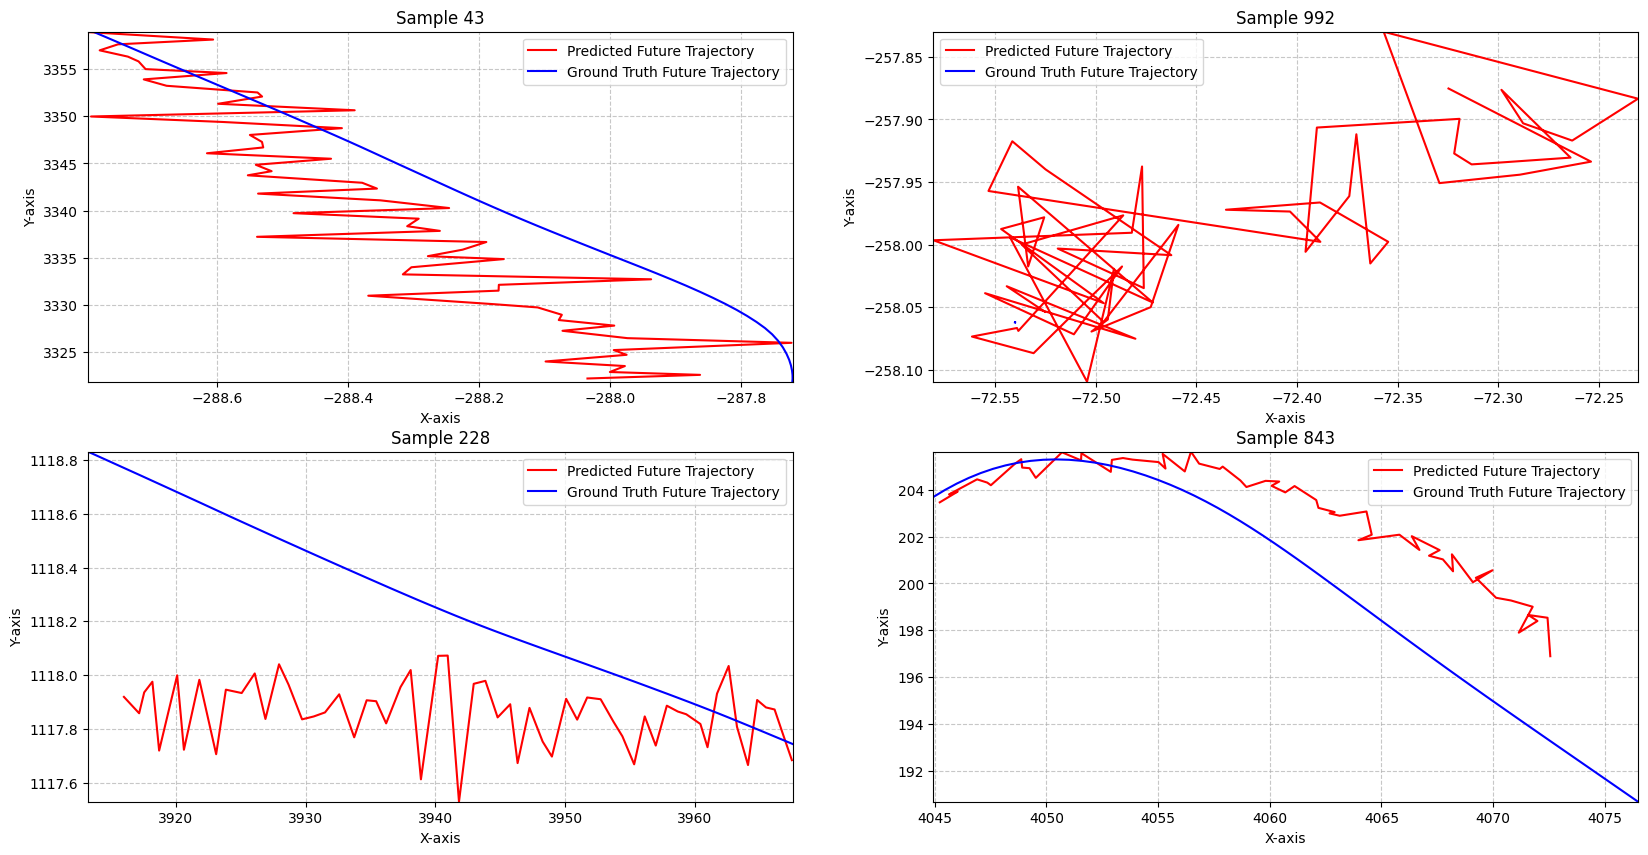

In [24]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

In [21]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
model = TransformerModel(d_model=512, nhead=64, num_layers=4).to(device)
model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())

pred_list = np.concatenate(pred_list, axis=0)
pred_output = pred_list.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)